Loading dataset

In [ ]:
!pip install kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c santander-customer-transaction-prediction

In [ ]:
!unzip santander-customer-transaction-prediction.zip

In [ ]:
!pip install xgboost
!pip install lightgbm
!pip install optuna

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna
import lightgbm as lgb

In [7]:
#Loading the training dataset
data = pd.read_csv('train.csv')
data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [8]:
data.shape

(200000, 202)

In [9]:
#Displaying info of the dataset
print("Dataset Info:")
print(data.info())

#Checking for null values in the dataset
print("\nNull Values in the Dataset:")
null_values = data.isnull().sum()
if null_values.sum() == 0:
  print("No null values found in the dataset.")
else:
  print(null_values[null_values > 0])

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB
None

Null Values in the Dataset:
No null values found in the dataset.


Feature Engineering

In [10]:
#Dropping the 'ID_code' column from the DataFrame as it is not required
data = data.drop('ID_code', axis=1)

In [11]:
#Selecting numerical features
features = data.drop('target', axis=1)

#Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


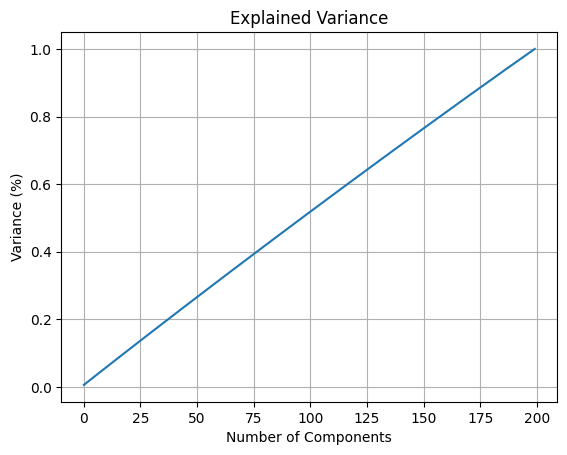

In [12]:
#Applying PCA
pca = PCA().fit(features_scaled)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')  # for each component
plt.title('Explained Variance')
plt.grid(True)
plt.show()

#Choosing the number of components e.g., 95% variance
pca = PCA(n_components=0.95)
principalComponents = pca.fit_transform(features_scaled)

#Creating a DataFrame with the principal components
principalDf = pd.DataFrame(data = principalComponents, columns = [f'Principal Component {i}' for i in range(principalComponents.shape[1])])


In [13]:
#Printing the number of components
print("Number of components selected:", pca.n_components_)

Number of components selected: 190


Splitting Data

In [14]:
#Merging the data
df = pd.concat([data['target'], principalDf], axis=1)
df.columns = df.columns.str.replace(' ', '_', regex=False)

In [15]:
#Splitting data into features and target
X = df.drop('target', axis=1)
y = df['target']

#Splitting the data into training and remaining data first
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

#Splitting the remaining data into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 120000 samples
Validation set size: 40000 samples
Testing set size: 40000 samples


Baseline Models

In [16]:
#Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

#Predicting on validation set
y_val_pred_log_reg = log_reg.predict_proba(X_val)[:, 1]

#Evaluating the model
log_reg_auc = roc_auc_score(y_val, y_val_pred_log_reg)

#Initializing the decision tree model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

#Predicting on validation set
y_val_pred_tree = decision_tree.predict_proba(X_val)[:, 1]

#Evaluating the model
tree_auc = roc_auc_score(y_val, y_val_pred_tree)

print(f'Logistic Regression ROC-AUC: {log_reg_auc}')
print(f'Decision Tree ROC-AUC: {tree_auc}')

Logistic Regression ROC-AUC: 0.8631566540490646
Decision Tree ROC-AUC: 0.6317903585863518


In [17]:
# Initialize and fit XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
# Predict on validation set
y_val_pred_xgb = xgb.predict_proba(X_val)[:, 1]
# Evaluate the model
xgb_auc = roc_auc_score(y_val, y_val_pred_xgb)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:35:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [18]:
#Initializing and fitting LightGBM
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)

#Predicting on validation set
y_val_pred_lgbm = lgbm.predict_proba(X_val)[:, 1]

#Evaluating the model
lgbm_auc = roc_auc_score(y_val, y_val_pred_lgbm)

print(f'XGBoost ROC-AUC: {xgb_auc}')
print(f'LightGBM ROC-AUC: {lgbm_auc}')


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
XGBoost ROC-AUC: 0.8528763506152468
LightGBM ROC-AUC: 0.8643179155501046


Hyperparameter Tuning

In [21]:
def objective(trial):
    # Hyperparameters to tune using the updated API
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'n_estimators': 1000
    }

    # Creating the LightGBM datasets
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_val, label=y_val)

    # Model training
    gbm = lgb.train(param, dtrain, valid_sets=[dvalid], callbacks=[lgb.early_stopping(10), lgb.log_evaluation(100)])

    # Validation prediction
    preds = gbm.predict(X_val, num_iteration=gbm.best_iteration)

    # Compute ROC-AUC score
    roc_auc = roc_auc_score(y_val, preds)
    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Best hyperparameters
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_value)

[I 2024-07-09 02:41:16,734] A new study created in memory with name: no-name-10d20b8b-f70b-47c4-ad26-2ac6801effd2
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.864848


[I 2024-07-09 02:41:23,694] Trial 0 finished with value: 0.8654990830135871 and parameters: {'lambda_l1': 1.1661928367209413, 'lambda_l2': 2.495842030678867, 'num_leaves': 87, 'feature_fraction': 0.8218513796224716, 'bagging_fraction': 0.40518722424289516, 'bagging_freq': 5, 'min_child_samples': 88, 'learning_rate': 0.062248876064170164}. Best is trial 0 with value: 0.8654990830135871.


Early stopping, best iteration is:
[122]	valid_0's auc: 0.865499


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 02:41:25,139] Trial 1 finished with value: 0.8613163925924444 and parameters: {'lambda_l1': 0.16453455081166263, 'lambda_l2': 0.0002531102084518325, 'num_leaves': 7, 'feature_fraction': 0.7624272022612932, 'bagging_fraction': 0.46947490330596714, 'bagging_freq': 3, 'min_child_samples': 67, 'learning_rate': 0.056793701533140006}. Best is trial 0 with value: 0.8654990830135871.


Early stopping, best iteration is:
[19]	valid_0's auc: 0.861316


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's auc: 0.862753


[I 2024-07-09 02:41:37,439] Trial 2 finished with value: 0.8627832691639263 and parameters: {'lambda_l1': 6.416405109765633, 'lambda_l2': 7.707809631458456e-07, 'num_leaves': 138, 'feature_fraction': 0.6165956608251744, 'bagging_fraction': 0.6354413831085205, 'bagging_freq': 2, 'min_child_samples': 51, 'learning_rate': 0.0019037819265184405}. Best is trial 0 with value: 0.8654990830135871.


Early stopping, best iteration is:
[99]	valid_0's auc: 0.862783


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.864595


[I 2024-07-09 02:41:45,663] Trial 3 finished with value: 0.8669781786775856 and parameters: {'lambda_l1': 1.8936244794659034e-08, 'lambda_l2': 0.35245677018092925, 'num_leaves': 119, 'feature_fraction': 0.6029441089307555, 'bagging_fraction': 0.418521291912712, 'bagging_freq': 4, 'min_child_samples': 95, 'learning_rate': 0.037056922929527544}. Best is trial 3 with value: 0.8669781786775856.


Early stopping, best iteration is:
[177]	valid_0's auc: 0.866978


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.864548


[I 2024-07-09 02:41:55,594] Trial 4 finished with value: 0.8661023576573702 and parameters: {'lambda_l1': 7.317579481449548e-06, 'lambda_l2': 1.160760335482163e-07, 'num_leaves': 21, 'feature_fraction': 0.8138295306613405, 'bagging_fraction': 0.6792051035009901, 'bagging_freq': 7, 'min_child_samples': 81, 'learning_rate': 0.05192737576604932}. Best is trial 3 with value: 0.8669781786775856.


Early stopping, best iteration is:
[164]	valid_0's auc: 0.866102


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 02:41:58,697] Trial 5 finished with value: 0.8632123149772646 and parameters: {'lambda_l1': 4.2090923988999914e-07, 'lambda_l2': 6.868857135663675, 'num_leaves': 46, 'feature_fraction': 0.7446090338161064, 'bagging_fraction': 0.5712445808616067, 'bagging_freq': 2, 'min_child_samples': 66, 'learning_rate': 0.03096993354331048}. Best is trial 3 with value: 0.8669781786775856.


Early stopping, best iteration is:
[65]	valid_0's auc: 0.863212


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.865734
[200]	valid_0's auc: 0.86726
[300]	valid_0's auc: 0.869079


[I 2024-07-09 02:42:34,000] Trial 6 finished with value: 0.8702032476598389 and parameters: {'lambda_l1': 6.242471157880766e-06, 'lambda_l2': 0.022894066047817394, 'num_leaves': 175, 'feature_fraction': 0.6793013068525424, 'bagging_fraction': 0.559109728966536, 'bagging_freq': 2, 'min_child_samples': 91, 'learning_rate': 0.01273207284211691}. Best is trial 6 with value: 0.8702032476598389.


Early stopping, best iteration is:
[369]	valid_0's auc: 0.870203


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.865988


[I 2024-07-09 02:42:47,192] Trial 7 finished with value: 0.8686393071358516 and parameters: {'lambda_l1': 1.4564953021391439e-07, 'lambda_l2': 0.21185672313732917, 'num_leaves': 63, 'feature_fraction': 0.7241792518368744, 'bagging_fraction': 0.6700413848343296, 'bagging_freq': 3, 'min_child_samples': 83, 'learning_rate': 0.05229968742336427}. Best is trial 6 with value: 0.8702032476598389.


Early stopping, best iteration is:
[183]	valid_0's auc: 0.868639


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.865826


[I 2024-07-09 02:43:00,490] Trial 8 finished with value: 0.8659269441122057 and parameters: {'lambda_l1': 2.0506057992245985, 'lambda_l2': 0.0027788475414693647, 'num_leaves': 124, 'feature_fraction': 0.6107119268264563, 'bagging_fraction': 0.570936977237213, 'bagging_freq': 3, 'min_child_samples': 95, 'learning_rate': 0.07174871207450974}. Best is trial 6 with value: 0.8702032476598389.


Early stopping, best iteration is:
[108]	valid_0's auc: 0.865927


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.861309
[200]	valid_0's auc: 0.862401
[300]	valid_0's auc: 0.863101
[400]	valid_0's auc: 0.863982
[500]	valid_0's auc: 0.864748


[I 2024-07-09 02:43:08,472] Trial 9 finished with value: 0.8652195729942378 and parameters: {'lambda_l1': 1.0228912599618541e-06, 'lambda_l2': 4.082710560420335e-06, 'num_leaves': 3, 'feature_fraction': 0.7789603817157935, 'bagging_fraction': 0.4387281498825649, 'bagging_freq': 4, 'min_child_samples': 15, 'learning_rate': 0.030355712395568432}. Best is trial 6 with value: 0.8702032476598389.


Early stopping, best iteration is:
[567]	valid_0's auc: 0.86522


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 02:43:19,271] Trial 10 finished with value: 0.8612294331544383 and parameters: {'lambda_l1': 0.00070523709390253, 'lambda_l2': 0.002765197339416768, 'num_leaves': 225, 'feature_fraction': 0.9898360141789634, 'bagging_fraction': 0.8724291279352178, 'bagging_freq': 1, 'min_child_samples': 32, 'learning_rate': 0.005706702624741017}. Best is trial 6 with value: 0.8702032476598389.


Early stopping, best iteration is:
[37]	valid_0's auc: 0.861229


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 02:43:20,913] Trial 11 finished with value: 0.8539780044349796 and parameters: {'lambda_l1': 0.00020008846481837716, 'lambda_l2': 0.033785638060687184, 'num_leaves': 189, 'feature_fraction': 0.5348675518587608, 'bagging_fraction': 0.8182553225268363, 'bagging_freq': 1, 'min_child_samples': 74, 'learning_rate': 0.19707547905388048}. Best is trial 6 with value: 0.8702032476598389.


Early stopping, best iteration is:
[2]	valid_0's auc: 0.853978


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863258
[200]	valid_0's auc: 0.865743
[300]	valid_0's auc: 0.867106
[400]	valid_0's auc: 0.868002


[I 2024-07-09 02:43:58,390] Trial 12 finished with value: 0.8680815406906353 and parameters: {'lambda_l1': 1.6248938440893698e-08, 'lambda_l2': 0.1049323126312107, 'num_leaves': 180, 'feature_fraction': 0.4679334898028028, 'bagging_fraction': 0.973975771133123, 'bagging_freq': 6, 'min_child_samples': 55, 'learning_rate': 0.009950975570957468}. Best is trial 6 with value: 0.8702032476598389.


Early stopping, best iteration is:
[411]	valid_0's auc: 0.868082


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.861823
[200]	valid_0's auc: 0.863642
[300]	valid_0's auc: 0.865005
[400]	valid_0's auc: 0.866384
[500]	valid_0's auc: 0.867397
[600]	valid_0's auc: 0.868294
[700]	valid_0's auc: 0.868976


[I 2024-07-09 02:44:42,340] Trial 13 finished with value: 0.8693119702452561 and parameters: {'lambda_l1': 2.5660825751348567e-05, 'lambda_l2': 6.25828923197494e-05, 'num_leaves': 63, 'feature_fraction': 0.9741914206010079, 'bagging_fraction': 0.7696863952480321, 'bagging_freq': 3, 'min_child_samples': 100, 'learning_rate': 0.011857310429094929}. Best is trial 6 with value: 0.8702032476598389.


Early stopping, best iteration is:
[748]	valid_0's auc: 0.869312


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.86256


[I 2024-07-09 02:44:59,339] Trial 14 finished with value: 0.8631920336255651 and parameters: {'lambda_l1': 8.694955766355395e-05, 'lambda_l2': 4.6502000863131936e-05, 'num_leaves': 171, 'feature_fraction': 0.9530766327896257, 'bagging_fraction': 0.7761425065367294, 'bagging_freq': 2, 'min_child_samples': 100, 'learning_rate': 0.004871457253777264}. Best is trial 6 with value: 0.8702032476598389.


Early stopping, best iteration is:
[151]	valid_0's auc: 0.863192


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.864328


[I 2024-07-09 02:45:18,103] Trial 15 finished with value: 0.865491265274012 and parameters: {'lambda_l1': 0.0032699380829874797, 'lambda_l2': 1.7185163600159545e-05, 'num_leaves': 254, 'feature_fraction': 0.8711324801734072, 'bagging_fraction': 0.7596544400531581, 'bagging_freq': 5, 'min_child_samples': 41, 'learning_rate': 0.014273095499294192}. Best is trial 6 with value: 0.8702032476598389.


Early stopping, best iteration is:
[148]	valid_0's auc: 0.865491


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.86184
Early stopping, best iteration is:
[94]	valid_0's auc: 0.8619


[I 2024-07-09 02:45:22,511] Trial 16 finished with value: 0.8619001573266709 and parameters: {'lambda_l1': 0.010761973538317947, 'lambda_l2': 0.0032506142330585392, 'num_leaves': 89, 'feature_fraction': 0.8967364209204991, 'bagging_fraction': 0.5323827895523007, 'bagging_freq': 2, 'min_child_samples': 78, 'learning_rate': 0.0010296881907870248}. Best is trial 6 with value: 0.8702032476598389.
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863485


[I 2024-07-09 02:45:36,822] Trial 17 finished with value: 0.8639459289038508 and parameters: {'lambda_l1': 1.7619750690025074e-05, 'lambda_l2': 0.0002788734112273195, 'num_leaves': 156, 'feature_fraction': 0.6680613520989372, 'bagging_fraction': 0.8778588113688347, 'bagging_freq': 3, 'min_child_samples': 6, 'learning_rate': 0.013122199060532117}. Best is trial 6 with value: 0.8702032476598389.


Early stopping, best iteration is:
[123]	valid_0's auc: 0.863946


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 02:45:49,472] Trial 18 finished with value: 0.8635362931258628 and parameters: {'lambda_l1': 5.537040609392802e-06, 'lambda_l2': 0.011893949060664806, 'num_leaves': 200, 'feature_fraction': 0.6825068734975872, 'bagging_fraction': 0.6202467560576342, 'bagging_freq': 1, 'min_child_samples': 90, 'learning_rate': 0.004678229084545269}. Best is trial 6 with value: 0.8702032476598389.


Early stopping, best iteration is:
[72]	valid_0's auc: 0.863536


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.865286
[200]	valid_0's auc: 0.868305
[300]	valid_0's auc: 0.869594


[I 2024-07-09 02:46:11,095] Trial 19 finished with value: 0.870497435743536 and parameters: {'lambda_l1': 3.353779821468619e-05, 'lambda_l2': 3.370359244126943e-08, 'num_leaves': 99, 'feature_fraction': 0.43615050147021267, 'bagging_fraction': 0.7308874099371419, 'bagging_freq': 4, 'min_child_samples': 100, 'learning_rate': 0.019478526594411596}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[367]	valid_0's auc: 0.870497


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 02:46:12,756] Trial 20 finished with value: 0.8564927129609602 and parameters: {'lambda_l1': 0.026476778700636243, 'lambda_l2': 1.522819157108943e-08, 'num_leaves': 100, 'feature_fraction': 0.42896960343296936, 'bagging_fraction': 0.5043401873521207, 'bagging_freq': 5, 'min_child_samples': 70, 'learning_rate': 0.021576631829333098}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[7]	valid_0's auc: 0.856493


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 02:46:23,004] Trial 21 finished with value: 0.863293254411404 and parameters: {'lambda_l1': 5.4765930056466387e-05, 'lambda_l2': 1.6800973468557792e-08, 'num_leaves': 62, 'feature_fraction': 0.5148147892584883, 'bagging_fraction': 0.7479340091507435, 'bagging_freq': 4, 'min_child_samples': 99, 'learning_rate': 0.008151859987028795}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[71]	valid_0's auc: 0.863293


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.864747


[I 2024-07-09 02:46:30,450] Trial 22 finished with value: 0.8656389826686637 and parameters: {'lambda_l1': 0.0007946703694500671, 'lambda_l2': 1.097349366014455e-06, 'num_leaves': 146, 'feature_fraction': 0.533373913688828, 'bagging_fraction': 0.7279689173264517, 'bagging_freq': 4, 'min_child_samples': 87, 'learning_rate': 0.018679544022762316}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[128]	valid_0's auc: 0.865639


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 02:46:39,666] Trial 23 finished with value: 0.8620096986670535 and parameters: {'lambda_l1': 2.0762700562589186e-06, 'lambda_l2': 5.866942331530519e-05, 'num_leaves': 106, 'feature_fraction': 0.41554232695597254, 'bagging_fraction': 0.8449612164724765, 'bagging_freq': 3, 'min_child_samples': 100, 'learning_rate': 0.0028735360853146645}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[63]	valid_0's auc: 0.86201


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 02:46:41,950] Trial 24 finished with value: 0.8605152017116978 and parameters: {'lambda_l1': 3.388727229603925e-05, 'lambda_l2': 2.087685058324794e-07, 'num_leaves': 43, 'feature_fraction': 0.9141334503164049, 'bagging_fraction': 0.9204352710035834, 'bagging_freq': 2, 'min_child_samples': 90, 'learning_rate': 0.00800439092769981}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[34]	valid_0's auc: 0.860515


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863775
[200]	valid_0's auc: 0.865787
Early stopping, best iteration is:
[196]	valid_0's auc: 0.865841


[I 2024-07-09 02:46:56,177] Trial 25 finished with value: 0.8658405632558069 and parameters: {'lambda_l1': 1.5588406451717234e-07, 'lambda_l2': 0.0008017895564027865, 'num_leaves': 72, 'feature_fraction': 0.6512835281507078, 'bagging_fraction': 0.7015035496056146, 'bagging_freq': 4, 'min_child_samples': 62, 'learning_rate': 0.020052187279779792}. Best is trial 19 with value: 0.870497435743536.
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 02:46:58,966] Trial 26 finished with value: 0.8598945214045612 and parameters: {'lambda_l1': 5.244011448230505e-06, 'lambda_l2': 0.0222019193551679, 'num_leaves': 160, 'feature_fraction': 0.5667776212281008, 'bagging_fraction': 0.7977441177464799, 'bagging_freq': 6, 'min_child_samples': 79, 'learning_rate': 0.11034132811572177}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[26]	valid_0's auc: 0.859895


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.865671
[200]	valid_0's auc: 0.868553


[I 2024-07-09 02:47:29,872] Trial 27 finished with value: 0.8701062456982199 and parameters: {'lambda_l1': 0.0005037087147289566, 'lambda_l2': 6.348220838324549e-06, 'num_leaves': 204, 'feature_fraction': 0.4671337914168776, 'bagging_fraction': 0.6383966239005852, 'bagging_freq': 3, 'min_child_samples': 92, 'learning_rate': 0.012107682029398537}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[272]	valid_0's auc: 0.870106


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 02:47:35,859] Trial 28 finished with value: 0.8653426111281866 and parameters: {'lambda_l1': 0.002399865624449118, 'lambda_l2': 8.003866382603569e-08, 'num_leaves': 207, 'feature_fraction': 0.47104120516625103, 'bagging_fraction': 0.6181950810325442, 'bagging_freq': 5, 'min_child_samples': 92, 'learning_rate': 0.003407176229252939}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[85]	valid_0's auc: 0.865343


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.864552
[200]	valid_0's auc: 0.867334
[300]	valid_0's auc: 0.869253


[I 2024-07-09 02:48:09,436] Trial 29 finished with value: 0.8695999385766747 and parameters: {'lambda_l1': 0.0002936388317336534, 'lambda_l2': 5.050748937341458e-06, 'num_leaves': 227, 'feature_fraction': 0.4638755598345277, 'bagging_fraction': 0.5709022212895307, 'bagging_freq': 5, 'min_child_samples': 85, 'learning_rate': 0.0071408858899301006}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[329]	valid_0's auc: 0.8696


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.866392
[200]	valid_0's auc: 0.86949


[I 2024-07-09 02:48:37,574] Trial 30 finished with value: 0.8695442845363506 and parameters: {'lambda_l1': 0.05785382508082231, 'lambda_l2': 1.4790008325096757, 'num_leaves': 256, 'feature_fraction': 0.40803011206367, 'bagging_fraction': 0.5200248643004415, 'bagging_freq': 2, 'min_child_samples': 75, 'learning_rate': 0.022937431669734477}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[198]	valid_0's auc: 0.869544


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.865388
[200]	valid_0's auc: 0.867983
[300]	valid_0's auc: 0.869593
Early stopping, best iteration is:
[307]	valid_0's auc: 0.869775


[I 2024-07-09 02:49:09,910] Trial 31 finished with value: 0.869775131709798 and parameters: {'lambda_l1': 0.00016200805242195317, 'lambda_l2': 5.249819623627301e-06, 'num_leaves': 230, 'feature_fraction': 0.47418263985286974, 'bagging_fraction': 0.5773024669921758, 'bagging_freq': 5, 'min_child_samples': 84, 'learning_rate': 0.00931492466405104}. Best is trial 19 with value: 0.870497435743536.
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 02:49:11,613] Trial 32 finished with value: 0.851238014139584 and parameters: {'lambda_l1': 0.00015840696988427133, 'lambda_l2': 5.656823924645342e-07, 'num_leaves': 226, 'feature_fraction': 0.496580706732744, 'bagging_fraction': 0.6454374270757368, 'bagging_freq': 6, 'min_child_samples': 87, 'learning_rate': 0.014744324832590758}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[2]	valid_0's auc: 0.851238


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.865783
[200]	valid_0's auc: 0.867741


[I 2024-07-09 02:49:31,843] Trial 33 finished with value: 0.8679243731297306 and parameters: {'lambda_l1': 0.000908296235406178, 'lambda_l2': 5.5184003937942395e-06, 'num_leaves': 214, 'feature_fraction': 0.5731221182938451, 'bagging_fraction': 0.5885754113720832, 'bagging_freq': 4, 'min_child_samples': 94, 'learning_rate': 0.009387623691790616}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[213]	valid_0's auc: 0.867924


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 02:49:45,066] Trial 34 finished with value: 0.8665484854038772 and parameters: {'lambda_l1': 1.1880046152970592e-05, 'lambda_l2': 3.019554472006529e-08, 'num_leaves': 240, 'feature_fraction': 0.4554349229818189, 'bagging_fraction': 0.4638568519292672, 'bagging_freq': 3, 'min_child_samples': 84, 'learning_rate': 0.016991487615776256}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[81]	valid_0's auc: 0.866548


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.864946


[I 2024-07-09 02:50:03,162] Trial 35 finished with value: 0.8664941193964173 and parameters: {'lambda_l1': 0.004574331169474536, 'lambda_l2': 1.690569846075581e-06, 'num_leaves': 196, 'feature_fraction': 0.5825670382953606, 'bagging_fraction': 0.711636666593058, 'bagging_freq': 5, 'min_child_samples': 56, 'learning_rate': 0.03727796231629199}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[162]	valid_0's auc: 0.866494


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 02:50:05,163] Trial 36 finished with value: 0.8533510596043682 and parameters: {'lambda_l1': 1.1038198487686501e-06, 'lambda_l2': 3.416508567939597e-07, 'num_leaves': 167, 'feature_fraction': 0.49065419384058057, 'bagging_fraction': 0.6651763677682703, 'bagging_freq': 6, 'min_child_samples': 71, 'learning_rate': 0.027678652810608183}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[7]	valid_0's auc: 0.853351


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863919
[200]	valid_0's auc: 0.866272


[I 2024-07-09 02:50:21,395] Trial 37 finished with value: 0.8663416700307629 and parameters: {'lambda_l1': 0.33905713166086515, 'lambda_l2': 1.3058865873406687e-05, 'num_leaves': 143, 'feature_fraction': 0.4399693840347111, 'bagging_fraction': 0.48214069015711825, 'bagging_freq': 4, 'min_child_samples': 63, 'learning_rate': 0.0034972593964579216}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[199]	valid_0's auc: 0.866342


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.862749


[I 2024-07-09 02:50:36,415] Trial 38 finished with value: 0.8639320498331512 and parameters: {'lambda_l1': 9.534988942201344e-05, 'lambda_l2': 4.9846463733995964e-08, 'num_leaves': 185, 'feature_fraction': 0.5349520336359882, 'bagging_fraction': 0.5972332303778816, 'bagging_freq': 7, 'min_child_samples': 48, 'learning_rate': 0.006241493665231535}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[137]	valid_0's auc: 0.863932


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.866546


[I 2024-07-09 02:50:52,256] Trial 39 finished with value: 0.8686980676083768 and parameters: {'lambda_l1': 7.163895368073367e-08, 'lambda_l2': 0.0009551490945594565, 'num_leaves': 118, 'feature_fraction': 0.644089380748715, 'bagging_fraction': 0.5476020175063141, 'bagging_freq': 3, 'min_child_samples': 94, 'learning_rate': 0.04066410620031902}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[189]	valid_0's auc: 0.868698


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 02:50:55,106] Trial 40 finished with value: 0.8611028649838974 and parameters: {'lambda_l1': 3.95245280768096e-06, 'lambda_l2': 1.8823012959770708e-06, 'num_leaves': 135, 'feature_fraction': 0.7172768732589545, 'bagging_fraction': 0.6739723409849574, 'bagging_freq': 3, 'min_child_samples': 83, 'learning_rate': 0.010846800517407567}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[26]	valid_0's auc: 0.861103


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.865066
[200]	valid_0's auc: 0.867605
[300]	valid_0's auc: 0.868705


[I 2024-07-09 02:51:28,355] Trial 41 finished with value: 0.8689292453998854 and parameters: {'lambda_l1': 0.0002694341467299141, 'lambda_l2': 0.00013917557391274484, 'num_leaves': 226, 'feature_fraction': 0.497682967485062, 'bagging_fraction': 0.562017117658109, 'bagging_freq': 5, 'min_child_samples': 89, 'learning_rate': 0.007425961337317481}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[318]	valid_0's auc: 0.868929


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.865854


[I 2024-07-09 02:51:46,028] Trial 42 finished with value: 0.86765698577263 and parameters: {'lambda_l1': 0.0004956220886196437, 'lambda_l2': 1.0359308087977678e-05, 'num_leaves': 237, 'feature_fraction': 0.401433857768517, 'bagging_fraction': 0.5955887298512936, 'bagging_freq': 5, 'min_child_samples': 84, 'learning_rate': 0.0065942259510689645}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[159]	valid_0's auc: 0.867657


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863766


[I 2024-07-09 02:52:02,499] Trial 43 finished with value: 0.864662509112402 and parameters: {'lambda_l1': 0.0015904269792894968, 'lambda_l2': 3.441052933947886e-06, 'num_leaves': 212, 'feature_fraction': 0.8089984235748346, 'bagging_fraction': 0.6504657658933333, 'bagging_freq': 4, 'min_child_samples': 95, 'learning_rate': 0.011230570771437885}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[143]	valid_0's auc: 0.864663


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863984


[I 2024-07-09 02:52:19,558] Trial 44 finished with value: 0.8650109529975387 and parameters: {'lambda_l1': 0.00024532496173243967, 'lambda_l2': 1.5200624747184324e-07, 'num_leaves': 238, 'feature_fraction': 0.4513041881132663, 'bagging_fraction': 0.6242836342840578, 'bagging_freq': 5, 'min_child_samples': 77, 'learning_rate': 0.0020913858519471624}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[139]	valid_0's auc: 0.865011


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.862767


[I 2024-07-09 02:52:33,034] Trial 45 finished with value: 0.8631102090993238 and parameters: {'lambda_l1': 3.019281430025196e-05, 'lambda_l2': 3.148477002591533e-05, 'num_leaves': 180, 'feature_fraction': 0.5538969341112823, 'bagging_fraction': 0.4225321592649572, 'bagging_freq': 6, 'min_child_samples': 28, 'learning_rate': 0.0049625106099701576}. Best is trial 19 with value: 0.870497435743536.


Early stopping, best iteration is:
[110]	valid_0's auc: 0.86311


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.865972
[200]	valid_0's auc: 0.868574
[300]	valid_0's auc: 0.870142
[400]	valid_0's auc: 0.871447
Early stopping, best iteration is:
[475]	valid_0's auc: 0.872206


[I 2024-07-09 02:53:21,260] Trial 46 finished with value: 0.8722062902965301 and parameters: {'lambda_l1': 0.008193037966402892, 'lambda_l2': 0.00012777054448225716, 'num_leaves': 199, 'feature_fraction': 0.6186968713117357, 'bagging_fraction': 0.5062599500755458, 'bagging_freq': 1, 'min_child_samples': 81, 'learning_rate': 0.016358114709472463}. Best is trial 46 with value: 0.8722062902965301.
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.865959
[200]	valid_0's auc: 0.86859


[I 2024-07-09 02:53:42,828] Trial 47 finished with value: 0.869084077970732 and parameters: {'lambda_l1': 0.012711877251464927, 'lambda_l2': 0.6261315945927459, 'num_leaves': 215, 'feature_fraction': 0.6297867484207015, 'bagging_fraction': 0.4985410304629786, 'bagging_freq': 1, 'min_child_samples': 80, 'learning_rate': 0.02800434045121421}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[231]	valid_0's auc: 0.869084


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.865967
[200]	valid_0's auc: 0.868141
[300]	valid_0's auc: 0.870077
[400]	valid_0's auc: 0.871276
Early stopping, best iteration is:
[455]	valid_0's auc: 0.871598


[I 2024-07-09 02:54:31,863] Trial 48 finished with value: 0.8715976844365081 and parameters: {'lambda_l1': 0.11316862230510105, 'lambda_l2': 0.00011663066225904116, 'num_leaves': 192, 'feature_fraction': 0.7757195697511962, 'bagging_fraction': 0.4544493477741005, 'bagging_freq': 1, 'min_child_samples': 97, 'learning_rate': 0.015102046285388825}. Best is trial 46 with value: 0.8722062902965301.
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 02:54:35,771] Trial 49 finished with value: 0.8632761724782353 and parameters: {'lambda_l1': 0.194176843540482, 'lambda_l2': 0.0008042615063602242, 'num_leaves': 194, 'feature_fraction': 0.7577974256836655, 'bagging_fraction': 0.4588990284578483, 'bagging_freq': 1, 'min_child_samples': 96, 'learning_rate': 0.06504468660203065}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[42]	valid_0's auc: 0.863276


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.865842
[200]	valid_0's auc: 0.868086
[300]	valid_0's auc: 0.870436


[I 2024-07-09 02:55:09,207] Trial 50 finished with value: 0.8709315992489487 and parameters: {'lambda_l1': 0.7166732440607881, 'lambda_l2': 0.00010175331734197, 'num_leaves': 174, 'feature_fraction': 0.8390450269992464, 'bagging_fraction': 0.40099092466314123, 'bagging_freq': 2, 'min_child_samples': 97, 'learning_rate': 0.015947511190153175}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[337]	valid_0's auc: 0.870932


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-09 02:55:22,602] Trial 51 finished with value: 0.8646481616661156 and parameters: {'lambda_l1': 3.931716383989862, 'lambda_l2': 0.00013266175136903493, 'num_leaves': 172, 'feature_fraction': 0.7913922616051967, 'bagging_fraction': 0.40984963193127916, 'bagging_freq': 2, 'min_child_samples': 97, 'learning_rate': 0.01575757215661838}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[114]	valid_0's auc: 0.864648


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 02:55:34,303] Trial 52 finished with value: 0.865121455196662 and parameters: {'lambda_l1': 0.8840656390829434, 'lambda_l2': 0.006304399887164187, 'num_leaves': 152, 'feature_fraction': 0.8668066381267959, 'bagging_fraction': 0.401230989676935, 'bagging_freq': 1, 'min_child_samples': 91, 'learning_rate': 0.02413013253438402}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[77]	valid_0's auc: 0.865121


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.865811


[I 2024-07-09 02:55:43,001] Trial 53 finished with value: 0.8662875244353437 and parameters: {'lambda_l1': 0.05150086383784404, 'lambda_l2': 0.0004101333303174586, 'num_leaves': 201, 'feature_fraction': 0.7390429460863177, 'bagging_fraction': 0.44328419987741413, 'bagging_freq': 2, 'min_child_samples': 97, 'learning_rate': 0.013341832078539515}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[122]	valid_0's auc: 0.866288


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.865133
[200]	valid_0's auc: 0.868011
[300]	valid_0's auc: 0.87


[I 2024-07-09 02:56:16,613] Trial 54 finished with value: 0.8708491995850385 and parameters: {'lambda_l1': 0.8986015282299551, 'lambda_l2': 9.084032984279188e-05, 'num_leaves': 179, 'feature_fraction': 0.8386440882589271, 'bagging_fraction': 0.481993327406088, 'bagging_freq': 1, 'min_child_samples': 93, 'learning_rate': 0.016141067399664855}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[355]	valid_0's auc: 0.870849


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-09 02:56:42,065] Trial 55 finished with value: 0.8665145350617044 and parameters: {'lambda_l1': 8.250162232276692, 'lambda_l2': 0.0001423511670584226, 'num_leaves': 128, 'feature_fraction': 0.6966133081922262, 'bagging_fraction': 0.4839672249982873, 'bagging_freq': 1, 'min_child_samples': 99, 'learning_rate': 0.016534051145433562}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[270]	valid_0's auc: 0.866515


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-07-09 02:56:49,113] Trial 56 finished with value: 0.8659632225565604 and parameters: {'lambda_l1': 0.5120348082852133, 'lambda_l2': 5.831470760106094, 'num_leaves': 177, 'feature_fraction': 0.8588407530477445, 'bagging_fraction': 0.4348457922254916, 'bagging_freq': 1, 'min_child_samples': 89, 'learning_rate': 0.046925895509076936}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[103]	valid_0's auc: 0.865963


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.86578
[200]	valid_0's auc: 0.868994


[I 2024-07-09 02:57:17,663] Trial 57 finished with value: 0.8692903078743627 and parameters: {'lambda_l1': 0.1476179018195462, 'lambda_l2': 0.0016383936706357957, 'num_leaves': 186, 'feature_fraction': 0.840753111895859, 'bagging_fraction': 0.5294285917870514, 'bagging_freq': 1, 'min_child_samples': 93, 'learning_rate': 0.03238707832483044}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[226]	valid_0's auc: 0.86929


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.864483
[200]	valid_0's auc: 0.866951
[300]	valid_0's auc: 0.869464
[400]	valid_0's auc: 0.870667
[500]	valid_0's auc: 0.871805


[I 2024-07-09 02:57:50,897] Trial 58 finished with value: 0.872005212524355 and parameters: {'lambda_l1': 1.1498392653436758, 'lambda_l2': 0.0003159549514333309, 'num_leaves': 83, 'feature_fraction': 0.7797685077389882, 'bagging_fraction': 0.4499571096724051, 'bagging_freq': 2, 'min_child_samples': 100, 'learning_rate': 0.01968912907488861}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[531]	valid_0's auc: 0.872005


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863978
[200]	valid_0's auc: 0.866239
[300]	valid_0's auc: 0.868442
[400]	valid_0's auc: 0.869796


[I 2024-07-09 02:58:21,651] Trial 59 finished with value: 0.8705193805173568 and parameters: {'lambda_l1': 2.4489861118518705, 'lambda_l2': 2.2676259141630268e-05, 'num_leaves': 87, 'feature_fraction': 0.7820601944104525, 'bagging_fraction': 0.45675892697874715, 'bagging_freq': 2, 'min_child_samples': 100, 'learning_rate': 0.019570744145018224}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[467]	valid_0's auc: 0.870519


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863606
[200]	valid_0's auc: 0.866355
[300]	valid_0's auc: 0.868382
[400]	valid_0's auc: 0.86982


[I 2024-07-09 02:58:40,966] Trial 60 finished with value: 0.8708960853588608 and parameters: {'lambda_l1': 2.5050921686644583, 'lambda_l2': 3.1057514919209706e-05, 'num_leaves': 34, 'feature_fraction': 0.7778377936846324, 'bagging_fraction': 0.4495912493580309, 'bagging_freq': 2, 'min_child_samples': 96, 'learning_rate': 0.0254233674303444}. Best is trial 46 with value: 0.8722062902965301.


[500]	valid_0's auc: 0.870868
Early stopping, best iteration is:
[490]	valid_0's auc: 0.870896


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863331
[200]	valid_0's auc: 0.865986
[300]	valid_0's auc: 0.867946
[400]	valid_0's auc: 0.869152
[500]	valid_0's auc: 0.870256


[I 2024-07-09 02:59:00,011] Trial 61 finished with value: 0.8706833877394053 and parameters: {'lambda_l1': 2.098111994617845, 'lambda_l2': 2.7656928121795134e-05, 'num_leaves': 27, 'feature_fraction': 0.772444650699744, 'bagging_fraction': 0.45022448725294606, 'bagging_freq': 2, 'min_child_samples': 97, 'learning_rate': 0.024883153841916507}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[539]	valid_0's auc: 0.870683


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863788
[200]	valid_0's auc: 0.866736
[300]	valid_0's auc: 0.868749
[400]	valid_0's auc: 0.86979


[I 2024-07-09 02:59:15,184] Trial 62 finished with value: 0.8703784270172097 and parameters: {'lambda_l1': 1.187700251938519, 'lambda_l2': 8.28150634396447e-05, 'num_leaves': 18, 'feature_fraction': 0.8115322229401147, 'bagging_fraction': 0.4275682030618384, 'bagging_freq': 2, 'min_child_samples': 97, 'learning_rate': 0.0320836114872948}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[443]	valid_0's auc: 0.870378


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863506
[200]	valid_0's auc: 0.866083
[300]	valid_0's auc: 0.868475
[400]	valid_0's auc: 0.869811
[500]	valid_0's auc: 0.870998


[I 2024-07-09 02:59:33,695] Trial 63 finished with value: 0.871121194931369 and parameters: {'lambda_l1': 3.456911047438564, 'lambda_l2': 0.0003821053636441385, 'num_leaves': 26, 'feature_fraction': 0.8356373104344397, 'bagging_fraction': 0.5055785720944047, 'bagging_freq': 2, 'min_child_samples': 87, 'learning_rate': 0.026138965096105242}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[509]	valid_0's auc: 0.871121


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.862733
[200]	valid_0's auc: 0.864658
[300]	valid_0's auc: 0.866787
[400]	valid_0's auc: 0.868223
[500]	valid_0's auc: 0.869304
[600]	valid_0's auc: 0.870299
[700]	valid_0's auc: 0.871133


[I 2024-07-09 03:00:06,891] Trial 64 finished with value: 0.8713634002127981 and parameters: {'lambda_l1': 4.918108403384346, 'lambda_l2': 0.0004022915493333351, 'num_leaves': 43, 'feature_fraction': 0.8954573754724341, 'bagging_fraction': 0.4841651535699682, 'bagging_freq': 1, 'min_child_samples': 89, 'learning_rate': 0.018023343456152276}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[744]	valid_0's auc: 0.871363


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 03:00:09,275] Trial 65 finished with value: 0.8621372793554072 and parameters: {'lambda_l1': 5.163510323746461, 'lambda_l2': 0.0004394123811932626, 'num_leaves': 42, 'feature_fraction': 0.921657604874428, 'bagging_fraction': 0.5078176567703404, 'bagging_freq': 2, 'min_child_samples': 87, 'learning_rate': 0.022058356734695743}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[47]	valid_0's auc: 0.862137


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.865168


[I 2024-07-09 03:00:18,844] Trial 66 finished with value: 0.8658816701014325 and parameters: {'lambda_l1': 0.10861002058894025, 'lambda_l2': 0.0002500199596447792, 'num_leaves': 34, 'feature_fraction': 0.8869264203807177, 'bagging_fraction': 0.4927318166239776, 'bagging_freq': 1, 'min_child_samples': 87, 'learning_rate': 0.08458737474916846}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[111]	valid_0's auc: 0.865882


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.862525
[200]	valid_0's auc: 0.865056
[300]	valid_0's auc: 0.866541
[400]	valid_0's auc: 0.86748


[I 2024-07-09 03:00:26,265] Trial 67 finished with value: 0.8675328386906006 and parameters: {'lambda_l1': 0.3856383813073799, 'lambda_l2': 0.0019472106358855105, 'num_leaves': 9, 'feature_fraction': 0.83096029599265, 'bagging_fraction': 0.5416024977996087, 'bagging_freq': 1, 'min_child_samples': 80, 'learning_rate': 0.035218988089679486}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[406]	valid_0's auc: 0.867533


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.864926
[200]	valid_0's auc: 0.86691


[I 2024-07-09 03:00:41,140] Trial 68 finished with value: 0.8680870303280286 and parameters: {'lambda_l1': 9.557125981638588, 'lambda_l2': 0.00467682749390766, 'num_leaves': 54, 'feature_fraction': 0.9433992926411126, 'bagging_fraction': 0.518165189360182, 'bagging_freq': 2, 'min_child_samples': 75, 'learning_rate': 0.04884271825398799}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[279]	valid_0's auc: 0.868087


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.864178
[200]	valid_0's auc: 0.866807
[300]	valid_0's auc: 0.869051


[I 2024-07-09 03:00:59,162] Trial 69 finished with value: 0.8693042420480727 and parameters: {'lambda_l1': 2.877020883188519, 'lambda_l2': 0.00020650825883628782, 'num_leaves': 68, 'feature_fraction': 0.7967505777103198, 'bagging_fraction': 0.4181040490637545, 'bagging_freq': 1, 'min_child_samples': 90, 'learning_rate': 0.025796280057120216}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[313]	valid_0's auc: 0.869304


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863508
[200]	valid_0's auc: 0.865653
[300]	valid_0's auc: 0.867631
[400]	valid_0's auc: 0.86915
[500]	valid_0's auc: 0.870341


[I 2024-07-09 03:01:27,130] Trial 70 finished with value: 0.8707167801635997 and parameters: {'lambda_l1': 1.0877148326777053, 'lambda_l2': 4.2605101610394973e-05, 'num_leaves': 51, 'feature_fraction': 0.7590520672761284, 'bagging_fraction': 0.4386090657406799, 'bagging_freq': 2, 'min_child_samples': 82, 'learning_rate': 0.01899784413065809}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[535]	valid_0's auc: 0.870717


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863551
[200]	valid_0's auc: 0.865852
[300]	valid_0's auc: 0.867316
[400]	valid_0's auc: 0.869375
[500]	valid_0's auc: 0.8706


[I 2024-07-09 03:01:59,515] Trial 71 finished with value: 0.871020521731694 and parameters: {'lambda_l1': 0.6189807888176728, 'lambda_l2': 7.584344202798259e-05, 'num_leaves': 80, 'feature_fraction': 0.8369930916683324, 'bagging_fraction': 0.4762514430968999, 'bagging_freq': 1, 'min_child_samples': 92, 'learning_rate': 0.013551038833668008}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[547]	valid_0's auc: 0.871021


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.862678
[200]	valid_0's auc: 0.864552
[300]	valid_0's auc: 0.865921
[400]	valid_0's auc: 0.867246


[I 2024-07-09 03:02:18,618] Trial 72 finished with value: 0.8681938612890959 and parameters: {'lambda_l1': 0.22624434517744244, 'lambda_l2': 0.00047696911977400256, 'num_leaves': 33, 'feature_fraction': 0.8545555296883157, 'bagging_fraction': 0.46974360290388295, 'bagging_freq': 1, 'min_child_samples': 93, 'learning_rate': 0.013455137236828955}. Best is trial 46 with value: 0.8722062902965301.


[500]	valid_0's auc: 0.868194
Early stopping, best iteration is:
[490]	valid_0's auc: 0.868194


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 03:02:21,697] Trial 73 finished with value: 0.8617504665554656 and parameters: {'lambda_l1': 0.5846848383065534, 'lambda_l2': 5.858036237438604e-05, 'num_leaves': 18, 'feature_fraction': 0.8936194488333062, 'bagging_fraction': 0.47938681341863487, 'bagging_freq': 2, 'min_child_samples': 86, 'learning_rate': 0.0094300526315366}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[87]	valid_0's auc: 0.86175


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863964
[200]	valid_0's auc: 0.866247
[300]	valid_0's auc: 0.868592
[400]	valid_0's auc: 0.870213
[500]	valid_0's auc: 0.87111


[I 2024-07-09 03:02:51,441] Trial 74 finished with value: 0.8713540533646892 and parameters: {'lambda_l1': 0.07363101976081703, 'lambda_l2': 0.001307333151516795, 'num_leaves': 72, 'feature_fraction': 0.8205642119604397, 'bagging_fraction': 0.46943396763482936, 'bagging_freq': 1, 'min_child_samples': 90, 'learning_rate': 0.017747556445303823}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[524]	valid_0's auc: 0.871354


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.864116
[200]	valid_0's auc: 0.866707
[300]	valid_0's auc: 0.868998


[I 2024-07-09 03:03:09,894] Trial 75 finished with value: 0.8695693632938778 and parameters: {'lambda_l1': 0.0764725925187891, 'lambda_l2': 0.0010472534199417805, 'num_leaves': 77, 'feature_fraction': 0.8241518735828731, 'bagging_fraction': 0.40079362944575536, 'bagging_freq': 1, 'min_child_samples': 70, 'learning_rate': 0.01740072381340541}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[321]	valid_0's auc: 0.869569


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 03:03:11,796] Trial 76 finished with value: 0.8613838800042134 and parameters: {'lambda_l1': 0.030346346415847554, 'lambda_l2': 0.00025662384488211987, 'num_leaves': 77, 'feature_fraction': 0.8749697896740873, 'bagging_fraction': 0.5131938004327017, 'bagging_freq': 1, 'min_child_samples': 90, 'learning_rate': 0.01139564443411338}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[14]	valid_0's auc: 0.861384


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863791


[I 2024-07-09 03:03:26,062] Trial 77 finished with value: 0.865258716795124 and parameters: {'lambda_l1': 1.3658329084410297, 'lambda_l2': 0.01004027366749518, 'num_leaves': 96, 'feature_fraction': 0.7300030150475428, 'bagging_fraction': 0.4678876693700204, 'bagging_freq': 1, 'min_child_samples': 32, 'learning_rate': 0.014381564210996883}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[178]	valid_0's auc: 0.865259


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863755
[200]	valid_0's auc: 0.866717
[300]	valid_0's auc: 0.869001


[I 2024-07-09 03:03:55,094] Trial 78 finished with value: 0.8695699349876089 and parameters: {'lambda_l1': 0.012954829095644054, 'lambda_l2': 0.0028577564781950052, 'num_leaves': 112, 'feature_fraction': 0.8493560192790227, 'bagging_fraction': 0.5311727555174237, 'bagging_freq': 1, 'min_child_samples': 77, 'learning_rate': 0.021400107799408635}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[339]	valid_0's auc: 0.86957


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.862683


[I 2024-07-09 03:03:59,327] Trial 79 finished with value: 0.8627433125936395 and parameters: {'lambda_l1': 0.23974579234871726, 'lambda_l2': 0.0641694940665981, 'num_leaves': 57, 'feature_fraction': 0.9132903002617412, 'bagging_fraction': 0.5021503362431504, 'bagging_freq': 1, 'min_child_samples': 82, 'learning_rate': 0.008677966064306512}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[105]	valid_0's auc: 0.862743


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.864821


[I 2024-07-09 03:04:13,074] Trial 80 finished with value: 0.8674250158753494 and parameters: {'lambda_l1': 0.022086478989753182, 'lambda_l2': 0.00010105387575234881, 'num_leaves': 80, 'feature_fraction': 0.8019750066259389, 'bagging_fraction': 0.43195565069758934, 'bagging_freq': 2, 'min_child_samples': 92, 'learning_rate': 0.04066706239917992}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[178]	valid_0's auc: 0.867425


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.864224
[200]	valid_0's auc: 0.867227
[300]	valid_0's auc: 0.869214


[I 2024-07-09 03:04:29,343] Trial 81 finished with value: 0.8695000643706478 and parameters: {'lambda_l1': 4.220285509318142, 'lambda_l2': 0.0005740864411512667, 'num_leaves': 47, 'feature_fraction': 0.8169473118524562, 'bagging_fraction': 0.44712560001719515, 'bagging_freq': 2, 'min_child_samples': 96, 'learning_rate': 0.02855442933701541}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[312]	valid_0's auc: 0.8695


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 03:04:31,205] Trial 82 finished with value: 0.8610802520860777 and parameters: {'lambda_l1': 0.6198399379595878, 'lambda_l2': 1.2626336145785427e-05, 'num_leaves': 40, 'feature_fraction': 0.7523091308790145, 'bagging_fraction': 0.4690859950409538, 'bagging_freq': 1, 'min_child_samples': 88, 'learning_rate': 0.012459767716977507}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.86108


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.86417
[200]	valid_0's auc: 0.866389
[300]	valid_0's auc: 0.868543
[400]	valid_0's auc: 0.869866
[500]	valid_0's auc: 0.870914


[I 2024-07-09 03:05:01,180] Trial 83 finished with value: 0.8710990090818785 and parameters: {'lambda_l1': 1.987401813940144, 'lambda_l2': 0.0014592735316997629, 'num_leaves': 62, 'feature_fraction': 0.7735239593800528, 'bagging_fraction': 0.4215369334124443, 'bagging_freq': 2, 'min_child_samples': 98, 'learning_rate': 0.01915406551553357}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[524]	valid_0's auc: 0.871099


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.86437
[200]	valid_0's auc: 0.866804
[300]	valid_0's auc: 0.86891
[400]	valid_0's auc: 0.870629
[500]	valid_0's auc: 0.871864


[I 2024-07-09 03:05:24,065] Trial 84 finished with value: 0.8719373600551432 and parameters: {'lambda_l1': 1.6077600956947498, 'lambda_l2': 0.0015090317821651953, 'num_leaves': 63, 'feature_fraction': 0.706724991662737, 'bagging_fraction': 0.41540534542434226, 'bagging_freq': 1, 'min_child_samples': 99, 'learning_rate': 0.018265381333850392}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[512]	valid_0's auc: 0.871937


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 03:05:33,807] Trial 85 finished with value: 0.8628853130509806 and parameters: {'lambda_l1': 1.5877955845918839, 'lambda_l2': 0.0013706035786905909, 'num_leaves': 86, 'feature_fraction': 0.6002758758264793, 'bagging_fraction': 0.4173927041644091, 'bagging_freq': 1, 'min_child_samples': 100, 'learning_rate': 0.018360032444313033}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[49]	valid_0's auc: 0.862885


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863409


[I 2024-07-09 03:05:38,415] Trial 86 finished with value: 0.8636098763081378 and parameters: {'lambda_l1': 6.295103102968506, 'lambda_l2': 0.0006622989977200503, 'num_leaves': 68, 'feature_fraction': 0.6680465246653838, 'bagging_fraction': 0.48504397138770394, 'bagging_freq': 1, 'min_child_samples': 94, 'learning_rate': 0.01078438607151452}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[116]	valid_0's auc: 0.86361


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.864164
[200]	valid_0's auc: 0.866438
[300]	valid_0's auc: 0.867978


[I 2024-07-09 03:05:56,405] Trial 87 finished with value: 0.8684070479477672 and parameters: {'lambda_l1': 0.006803510044791786, 'lambda_l2': 0.0054893238626803975, 'num_leaves': 64, 'feature_fraction': 0.7049150604348864, 'bagging_fraction': 0.5473670377733122, 'bagging_freq': 1, 'min_child_samples': 85, 'learning_rate': 0.021797494816730878}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[326]	valid_0's auc: 0.868407


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863769
[200]	valid_0's auc: 0.865578
[300]	valid_0's auc: 0.867394
[400]	valid_0's auc: 0.86923
[500]	valid_0's auc: 0.870412


[I 2024-07-09 03:06:26,452] Trial 88 finished with value: 0.871241567457198 and parameters: {'lambda_l1': 0.3489070010293789, 'lambda_l2': 0.002260315679074963, 'num_leaves': 57, 'feature_fraction': 0.7384452082673777, 'bagging_fraction': 0.4272992757998126, 'bagging_freq': 1, 'min_child_samples': 91, 'learning_rate': 0.014749306156115772}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[575]	valid_0's auc: 0.871242


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863333
[200]	valid_0's auc: 0.865599
[300]	valid_0's auc: 0.867528
[400]	valid_0's auc: 0.868941


[I 2024-07-09 03:06:47,030] Trial 89 finished with value: 0.8697209172356161 and parameters: {'lambda_l1': 0.06243725754577628, 'lambda_l2': 0.0023704343494098702, 'num_leaves': 60, 'feature_fraction': 0.7298271714509406, 'bagging_fraction': 0.42089446766123345, 'bagging_freq': 1, 'min_child_samples': 98, 'learning_rate': 0.015082882292294177}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[460]	valid_0's auc: 0.869721


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863303
[200]	valid_0's auc: 0.866048
[300]	valid_0's auc: 0.867874
[400]	valid_0's auc: 0.869486


[I 2024-07-09 03:07:13,189] Trial 90 finished with value: 0.8699881806109436 and parameters: {'lambda_l1': 0.3696763860292849, 'lambda_l2': 0.008827331232443635, 'num_leaves': 51, 'feature_fraction': 0.7081041700613453, 'bagging_fraction': 0.43441995877181233, 'bagging_freq': 1, 'min_child_samples': 89, 'learning_rate': 0.019304865751696678}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[449]	valid_0's auc: 0.869988


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.864159
[200]	valid_0's auc: 0.866181
[300]	valid_0's auc: 0.867526
[400]	valid_0's auc: 0.869135
[500]	valid_0's auc: 0.870204


[I 2024-07-09 03:07:48,114] Trial 91 finished with value: 0.8709557412553021 and parameters: {'lambda_l1': 0.1028356295129053, 'lambda_l2': 0.00030383155418093347, 'num_leaves': 94, 'feature_fraction': 0.7437204601074255, 'bagging_fraction': 0.46771646156318153, 'bagging_freq': 1, 'min_child_samples': 92, 'learning_rate': 0.013487234691163728}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[567]	valid_0's auc: 0.870956


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863619
[200]	valid_0's auc: 0.865612
[300]	valid_0's auc: 0.868023
[400]	valid_0's auc: 0.869514


[I 2024-07-09 03:08:10,797] Trial 92 finished with value: 0.8705693864991328 and parameters: {'lambda_l1': 1.5550886235649821, 'lambda_l2': 0.017852875377734265, 'num_leaves': 69, 'feature_fraction': 0.7676601045145032, 'bagging_fraction': 0.45840082569946317, 'bagging_freq': 1, 'min_child_samples': 95, 'learning_rate': 0.017131099943233218}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[472]	valid_0's auc: 0.870569


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 03:08:20,680] Trial 93 finished with value: 0.862708329070025 and parameters: {'lambda_l1': 3.419522619624815, 'lambda_l2': 0.0013295076391712606, 'num_leaves': 80, 'feature_fraction': 0.6837931407496752, 'bagging_fraction': 0.48917121057981383, 'bagging_freq': 1, 'min_child_samples': 91, 'learning_rate': 0.012289764113771693}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[61]	valid_0's auc: 0.862708


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 03:08:22,827] Trial 94 finished with value: 0.8606124240853577 and parameters: {'lambda_l1': 0.1808644779103197, 'lambda_l2': 0.00016546139261136615, 'num_leaves': 106, 'feature_fraction': 0.7871748951022636, 'bagging_fraction': 0.9829533810309831, 'bagging_freq': 1, 'min_child_samples': 100, 'learning_rate': 0.010193267050187705}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[17]	valid_0's auc: 0.860612


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 03:08:24,731] Trial 95 finished with value: 0.861795668243538 and parameters: {'lambda_l1': 0.2984948854194213, 'lambda_l2': 0.000799142511977209, 'num_leaves': 23, 'feature_fraction': 0.8024257313524827, 'bagging_fraction': 0.44363138705162064, 'bagging_freq': 2, 'min_child_samples': 94, 'learning_rate': 0.023229103739538265}. Best is trial 46 with value: 0.8722062902965301.


Early stopping, best iteration is:
[31]	valid_0's auc: 0.861796


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863717
[200]	valid_0's auc: 0.866147
[300]	valid_0's auc: 0.868235
[400]	valid_0's auc: 0.869918
[500]	valid_0's auc: 0.870909
[600]	valid_0's auc: 0.872086
[700]	valid_0's auc: 0.872728
Early stopping, best iteration is:
[719]	valid_0's auc: 0.872867


[I 2024-07-09 03:09:01,129] Trial 96 finished with value: 0.8728667205376655 and parameters: {'lambda_l1': 0.039076152897457965, 'lambda_l2': 0.003960763919615024, 'num_leaves': 73, 'feature_fraction': 0.7234039183517194, 'bagging_fraction': 0.41126972243069154, 'bagging_freq': 1, 'min_child_samples': 86, 'learning_rate': 0.01462750265655845}. Best is trial 96 with value: 0.8728667205376655.
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863339


[I 2024-07-09 03:09:12,266] Trial 97 finished with value: 0.8646096584377232 and parameters: {'lambda_l1': 0.019945998210254483, 'lambda_l2': 0.003741146966968802, 'num_leaves': 48, 'feature_fraction': 0.7269576612080593, 'bagging_fraction': 0.41964416055066217, 'bagging_freq': 2, 'min_child_samples': 23, 'learning_rate': 0.0206030993485737}. Best is trial 96 with value: 0.8728667205376655.


Early stopping, best iteration is:
[168]	valid_0's auc: 0.86461


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 03:09:15,760] Trial 98 finished with value: 0.8636294516525191 and parameters: {'lambda_l1': 0.1128482705688077, 'lambda_l2': 0.013964868316593411, 'num_leaves': 73, 'feature_fraction': 0.6949794529871265, 'bagging_fraction': 0.9482736821360253, 'bagging_freq': 3, 'min_child_samples': 86, 'learning_rate': 0.029692965389442508}. Best is trial 96 with value: 0.8728667205376655.


Early stopping, best iteration is:
[66]	valid_0's auc: 0.863629


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds


[I 2024-07-09 03:09:17,770] Trial 99 finished with value: 0.8599686280654332 and parameters: {'lambda_l1': 5.686949986002265, 'lambda_l2': 0.03688713914956788, 'num_leaves': 58, 'feature_fraction': 0.6599363015665128, 'bagging_fraction': 0.45398937320407806, 'bagging_freq': 1, 'min_child_samples': 50, 'learning_rate': 0.17788538150639613}. Best is trial 96 with value: 0.8728667205376655.


Early stopping, best iteration is:
[23]	valid_0's auc: 0.859969
Best trial: {'lambda_l1': 0.039076152897457965, 'lambda_l2': 0.003960763919615024, 'num_leaves': 73, 'feature_fraction': 0.7234039183517194, 'bagging_fraction': 0.41126972243069154, 'bagging_freq': 1, 'min_child_samples': 86, 'learning_rate': 0.01462750265655845}
Best score: 0.8728667205376655


Training and Testing Final Model

In [25]:
#Training the best model
best_params = study.best_trial.params
best_params.update({'metric': 'auc', 'objective': 'binary'})
final_model = lgb.train(best_params, lgb.Dataset(X_train, label=y_train), valid_sets=[lgb.Dataset(X_val, label=y_val)],
                        callbacks=[lgb.early_stopping(10), lgb.log_evaluation(100)])

#Testing prediction
test_preds = final_model.predict(X_test, num_iteration=final_model.best_iteration)
test_roc_auc = roc_auc_score(y_test, test_preds)
print(f'\nTest ROC-AUC: {test_roc_auc}')

[LightGBM] [Info] Number of positive: 11996, number of negative: 108004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48450
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099967 -> initscore=-2.197595
[LightGBM] [Info] Start training from score -2.197595
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.863717
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.863744

Test ROC-AUC: 0.8618018490745643
